In [1]:
from time import time
import numpy as np
from scipy import linalg
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix, issparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.utils._openmp_helpers import _openmp_effective_n_threads
from sklearn.utils.validation import check_non_negative
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

MACHINE_EPSILON = np.finfo(np.double).eps

In [2]:
def _joint_probabilities(X, degrees_of_freedom):
    dist = pdist(X, "sqeuclidean")
    dist += 1.
    dist **= (-degrees_of_freedom)
    P= np.maximum(dist / ( np.sum(dist)), MACHINE_EPSILON)
    return P


def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components,
                  skip_num_points=0, compute_error=True):

    X_embedded = params.reshape(n_samples, n_components)
    dist = pdist(X_embedded, "sqeuclidean")
    Dist=dist+ 1.
    dist= Dist**(-degrees_of_freedom)
    Q = np.maximum(dist / (np.sum(dist)), MACHINE_EPSILON)
    dist1=Dist**(-1)
    kl_divergence =np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist1)
    for i in range(skip_num_points, n_samples):
        grad[i] = np.dot(np.ravel(PQd[i]),
                        X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2*(degrees_of_freedom + 1.0) 
    grad *= c

    return kl_divergence, grad

def _gradient_descent(objective, p0, it, n_iter,
                     n_iter_check=1, n_iter_without_progress=300,
                     momentum=0.5, learning_rate=7, min_gain=0.01,
                     min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    tic = time()
    for i in range(it, n_iter):
        check_convergence = (i + 1) % n_iter_check == 0
       
        kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:
            toc = time()
            duration = toc - tic
            tic = toc

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                     " gradient norm = %.7f"
                     " (%s iterations in %0.3fs)"
                     % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                         "during the last %d episodes. Finished."
                         % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                         % (i + 1, grad_norm))
                break

    return p, error, i

#@ray.remote
class SDD(BaseEstimator):
   
   
    _EXPLORATION_N_ITER = 300
    _N_ITER_CHECK =50
    def _fit(self, X, degrees_of_freedom, skip_num_points=0):
        random_state=None
        n_samples=X.shape[0]
        P = _joint_probabilities(X,degrees_of_freedom)

        random_state = check_random_state(random_state)

        X_embedded = 1e-4 * random_state.randn(
               n_samples, 2).astype(np.float32)

        return self._tsne(P, degrees_of_freedom, n_samples,X_embedded=X_embedded,skip_num_points=skip_num_points)
    def _tsne(self, P, degrees_of_freedom, n_samples, X_embedded, skip_num_points=0):
        """Runs t-SNE."""
        params = X_embedded.ravel()

        opt_args = {
           "it": 0,
           "n_iter_check": 50,
           "min_grad_norm": 1e-7,
           "learning_rate": 7,
           "verbose": 0,
           "kwargs": dict(skip_num_points=skip_num_points),
           "args": [P, degrees_of_freedom, n_samples, 2],
           "n_iter_without_progress": 300,
           "n_iter": 300,
           "momentum": 0.8,
       }
        obj_func = _kl_divergence

        params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                     **opt_args)
        P /= 1
        remaining =2000 - 300
        if it < 300 or remaining > 0:
            opt_args['n_iter'] = 2000
            opt_args['it'] = it + 1
            opt_args['momentum'] = 0.8
            opt_args['n_iter_without_progress'] = 300
            params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                         **opt_args)

        self.n_iter_ = it
        X_embedded = params.reshape(n_samples, 2)
        self.kl_divergence_ = kl_divergence

        return X_embedded

In [3]:
import pandas as pd
import numpy as np
import ray
ray.init(ignore_reinit_error=True)

2022-08-10 11:14:46,750	INFO services.py:1476 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.7.5', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': 'tcp://127.0.0.1:57827', 'raylet_socket_name': 'tcp://127.0.0.1:59596', 'webui_url': '127.0.0.1:8265', 'session_dir': 'C:\\Users\\LSBU_D~1\\AppData\\Local\\Temp\\ray\\session_2022-08-10_11-14-44_114762_22956', 'metrics_export_port': 58715, 'gcs_address': '127.0.0.1:62622', 'address': '127.0.0.1:62622', 'node_id': '2be2446fad05046706dcdf4bb4538a2d34c97b16bbc78938f7510995'})

In [4]:
@ray.remote(num_cpus=8)
def read_files(x):
    x=pd.read_csv(x,nrows=160000,low_memory=False)
    return x

In [5]:
%%time
df=ray.get(read_files.remote('original947.csv'))

Wall time: 21.7 s


In [6]:
import random
random.seed(10)
random_num=random.sample(range(len(df)),5000)

In [7]:
random_num[:5]

[149789, 8541, 112430, 126500, 151543]

In [8]:
sample=df.iloc[random_num]

In [9]:
dead=sample[sample['Survive']==0].reset_index().loc[:499,:]
alive=sample[sample['Survive']==1].reset_index().loc[:499,:]
DF=pd.concat([dead,alive],axis=0)

In [14]:
DF.to_csv('1000_records.csv',index=False) #save the data for reference and lookup

In [10]:
y=DF[['Survive']]
DF=DF.drop(['Survive'],axis=1)
X=DF.loc[:,'_1_MAR_STAT':].copy()
X.shape

(1000, 946)

In [11]:
X.columns=range(X.shape[1])
X

,0,1,2,3,4,5,6,7,8,9,...,936,937,938,939,940,941,942,943,944,945
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
%%time

import scipy
A=scipy.spatial.distance.pdist(X, metric='euclidean')
kendSDD=[]

for k in range(1,15):
    print('loop started:',k)
    embedding = SDD()
    X_SDD = embedding._fit(X,degrees_of_freedom=k)
    B=scipy.spatial.distance.pdist(X_SDD, metric='euclidean')
    kendSDD.append(scipy.stats.kendalltau(A, B))

loop started: 1


C:\Users\LSBU_DeepLearning\Anaconda3\envs\raynew\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\LSBU_DeepLearning\Anaconda3\envs\raynew\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


loop started: 2
loop started: 3
loop started: 4
loop started: 5
loop started: 6
loop started: 7
loop started: 8
loop started: 9
loop started: 10
loop started: 11
loop started: 12
loop started: 13
loop started: 14
Wall time: 9min 55s


In [13]:
kendSDD

[KendalltauResult(correlation=0.7251442810038422, pvalue=0.0),
 KendalltauResult(correlation=0.7215502322435484, pvalue=0.0),
 KendalltauResult(correlation=0.6484191811635025, pvalue=0.0),
 KendalltauResult(correlation=0.5787860306630418, pvalue=0.0),
 KendalltauResult(correlation=0.027093388709615546, pvalue=3.667998475333065e-177),
 KendalltauResult(correlation=0.034993371269375545, pvalue=3.9646167931677726e-294),
 KendalltauResult(correlation=0.02075713500915707, pvalue=8.20175380782852e-105),
 KendalltauResult(correlation=0.00983037219308806, pvalue=7.280465676720321e-25),
 KendalltauResult(correlation=0.002327685987738248, pvalue=0.014762992030663764),
 KendalltauResult(correlation=-0.011351100032697563, pvalue=1.3381742642243783e-32),
 KendalltauResult(correlation=0.03401746499522871, pvalue=4.526893809925969e-278),
 KendalltauResult(correlation=0.0058771934525152, pvalue=7.456587243638164e-10),
 KendalltauResult(correlation=-0.0074184259157899154, pvalue=7.820649256571314e-15),

In [14]:
embedding=SDD()
X_SDD = embedding._fit(X,degrees_of_freedom=(kendSDD.index(max(kendSDD))+1))

C:\Users\LSBU_DeepLearning\Anaconda3\envs\raynew\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\LSBU_DeepLearning\Anaconda3\envs\raynew\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [15]:
y.shape

(1000, 1)

In [16]:
mapping={0:'passed away',1:'survived'}
y['mapped']=y['Survive'].map(mapping)

In [17]:
indexes=DF[['index']].values.flatten()

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

li=['p-'+str(i) for i in indexes]

In [19]:
y

,Survive,mapped
0,0.0,passed away
1,0.0,passed away
2,0.0,passed away
3,0.0,passed away
4,0.0,passed away
...,...,...
495,1.0,survived
496,1.0,survived
497,1.0,survived
498,1.0,survived


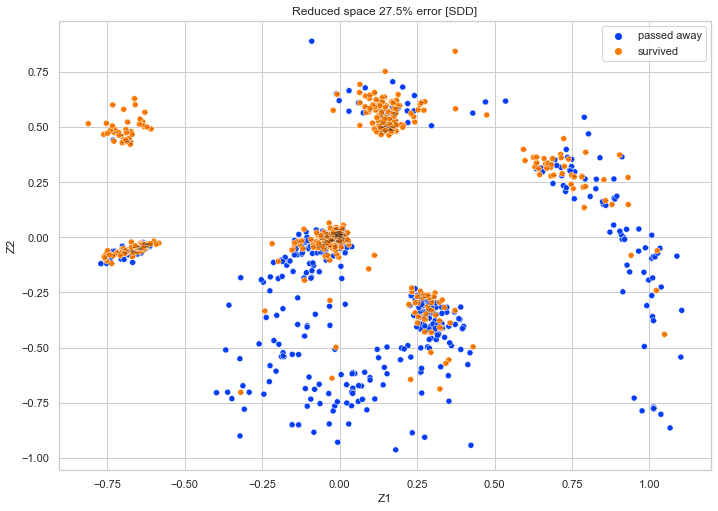

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
sns.set_style('whitegrid')

fig, ax = plt.subplots()
ax=sns.scatterplot(X_SDD[:,0], X_SDD[:,1], hue=np.array(y['mapped']).flatten(), legend='full',palette=palette)
for i, txt in enumerate(li):
    ax.annotate(txt, (X_SDD[i]),fontsize=0.0008)
resolution_value = 2048
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.title('Reduced space 27.5% error [SDD]')
plt.show()
#plt.savefig("pic1000_5confid_SDD.png", format="png", dpi=resolution_value)

### tsne

In [22]:
X

,0,1,2,3,4,5,6,7,8,9,...,936,937,938,939,940,941,942,943,944,945
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [30]:
%%time
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from MulticoreTSNE import MulticoreTSNE as TSNE
from scipy import stats
A=scipy.spatial.distance.pdist(X, metric='euclidean')
kendTSNE=[]

for k in range(1,1001,5):
    embedding = TSNE(n_jobs=8, perplexity=k,n_components=2)
    X_tsne = embedding.fit_transform(X)
    B=scipy.spatial.distance.pdist(X_tsne, metric='euclidean')
    kendTSNE.append(scipy.stats.kendalltau(A, B))

Wall time: 23min 39s


In [31]:
embedding=TSNE(n_jobs=8,perplexity=(kendTSNE.index(max(kendTSNE))+1),n_components=2)
X_tsne = embedding.fit_transform(X)

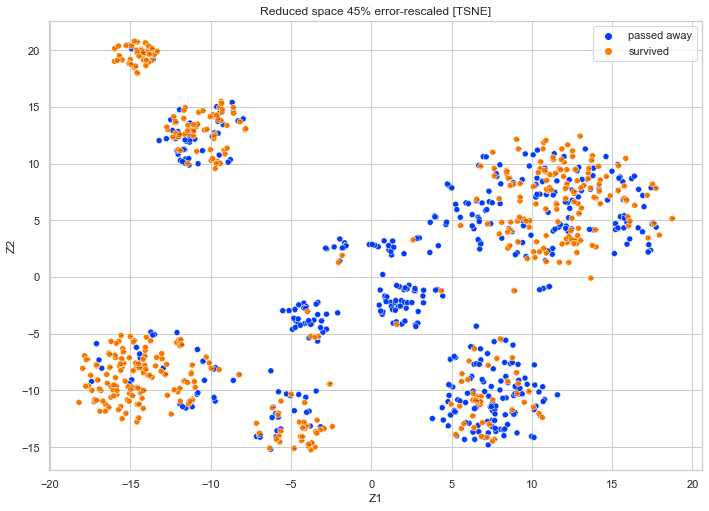

In [33]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
sns.set_style('whitegrid')

fig, ax = plt.subplots()
ax=sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=np.array(y['mapped']).flatten(), legend='full',palette=palette)
for i, txt in enumerate(li):
    ax.annotate(txt, (X_tsne[i]),fontsize=0.07)
resolution_value = 1080
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.title('Reduced space 45% error-rescaled [TSNE]')
plt.show()
#plt.savefig("pic500_5_tsnexxx_confid.png", format="png", dpi=resolution_value)

In [30]:
ray.shutdown()